<a href="https://colab.research.google.com/github/kangcshin/Kaggle_LANL-Earthquake-Prediction/blob/master/Earthquake.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#access kaggle datasets
!pip install kaggle
#math operations
!pip install numpy==1.15.0
#machine learning
!pip install catboost

In [0]:
#data preprocessing
import pandas as pd
#math operations
import numpy as np
#machine learning
from catboost import CatBoostRegressor, Pool
#data scaling
from sklearn.preprocessing import StandardScaler
#hyperparameter optimization
from sklearn.model_selection import GridSearchCV
#support vector machine model
from sklearn.svm import NuSVR, SVR
#kernel ridge model
from sklearn.kernel_ridge import KernelRidge
#data visualization
import matplotlib.pyplot as plt

In [3]:
#colab's file access feature
from google.colab import files
#retrieve uploaded file
uploaded = files.upload()
#move kaggle.json into the folder where the API expects to find
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/kaggle/kaggle.json

Saving kaggle.json to kaggle.json
chmod: cannot access '/root/kaggle/kaggle.json': No such file or directory


In [4]:
#list competitions
!kaggle competitions list
!ls

ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       2484           False  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge      10010            True  
house-prices-advanced-regression-techniques    2030-01-01 00:00:00  Getting Started  Knowledge       4070            True  
imagenet-object-localization-challenge         2029-12-31 07:00:00  Research         Knowledge         35           False  
competitive-data-science-predict-future-sales  2019-12-31 23:59:00  Playground           Kudos       2480           False  
two-sigma-financial-news                       2019-07-15 23:59:00  Featured          $100,000       2927           False  
LANL-Ear

In [5]:
#download earthquake data
!kaggle competitions download -c LANL-Earthquake-Prediction

  0% 0.00/33.3k [00:00<?, ?B/s]
100% 33.3k/33.3k [00:00<00:00, 13.8MB/s]
 93% 225M/242M [00:04<00:00, 44.9MB/s]
100% 242M/242M [00:04<00:00, 52.4MB/s]
100% 2.02G/2.03G [00:46<00:00, 46.1MB/s]
100% 2.03G/2.03G [00:46<00:00, 46.4MB/s]


In [6]:
#unziop training data for usage
!unzip train.csv.zip
!ls

Archive:  train.csv.zip
  inflating: train.csv               
sample_data  sample_submission.csv  test.zip  train.csv  train.csv.zip


In [0]:
#extract training data into a dataframe for further manipulation
train = pd.read_csv('train.csv', nrows=60000000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

In [8]:
#print first 10 entries
train.head(10)

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691
5,8,1.4691
6,9,1.4691
7,7,1.4691
8,-5,1.4691
9,3,1.4691


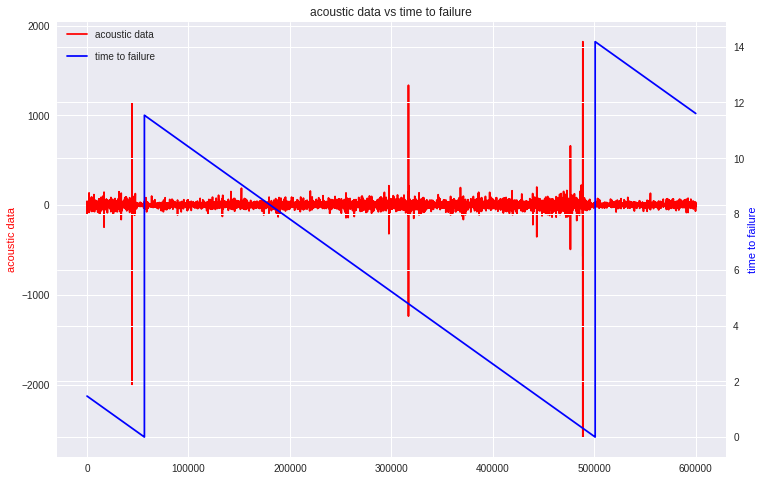

In [11]:
#EXPLORATORY DATA ANALYSIS
#visualize 1% of samples data, first 100 datapoints
train_ad_sample_df = train['acoustic_data'].values[::100]
train_ttf_sample_df = train['time_to_failure'].values[::100]

#plot based on both features
def plot_acc_tff_data (train_ad_sample_df, train_tff_sample_df, title = 'acoustic data vs time to failure'):
  fig, ax1 = plt.subplots(figsize = (12, 8))
  plt.title(title)
  plt.plot(train_ad_sample_df, color='r')
  ax1.set_ylabel('acoustic data', color='r')
  plt.legend(['acoustic data'], loc=(0.01, 0.95))
  ax2 = ax1.twinx()
  plt.plot(train_ttf_sample_df, color='b')
  ax2.set_ylabel('time to failure', color='b')
  plt.legend(['time to failure'], loc=(0.01, 0.9))
  plt.grid(True)
  
plot_acc_tff_data(train_ad_sample_df, train_ttf_sample_df)
del train_ad_sample_df
del train_ttf_sample_df

In [0]:
#FEATURE ENGINEERING
#generate some statistical features
def gen_features(X):
  strain = []
  strain.append(X.mean())
  strain.append(X.std())
  strain.append(X.min())
  #kurtosis is a measure of whether the data are heavy-tailed or light-tailed relative to a normal distribution
  #data sets with high kurtosis tend to have heavy tails, or outliers | data sets with low kurtosis tend to have light tails, or lack of outliers
  strain.append(X.kurtosis())
  strain.append(X.skew())
  #quantiles are cut points dividing the range of a probability distribution into continuous intervals with equl probabilites, or dividing the observations in a sample in the same way
  strain.append(np.quantile(X,0.01))
  return pd.Series(strain)

In [0]:
train = pd.read_csv('train.csv', iterator=True, chunksize=150_000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})
X_train = pd.DataFrame()
y_train = pd.Series()
for df in train:
  ch = gen_features(df['acoustic_data'])
  X_train = X_train.append(ch, ignore_index=True)
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))

In [17]:
X_train.describe()

,0,1,2,3,4,5
count,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000
mean,4.519475,6.547788,-149.190942,68.297997,0.125830,-11.224603
std,0.256049,8.503939,265.087984,70.532565,0.477901,14.106852
min,3.596313,2.802720,-5515.000000,0.648602,-4.091826,-336.000000
25%,4.349497,4.478637,-154.000000,28.090227,-0.040779,-14.000000
50%,4.522147,5.618798,-111.000000,45.816625,0.085620,-10.000000
75%,4.693350,6.880904,-79.000000,78.664202,0.253930,-6.000000
max,5.391993,153.703569,-15.000000,631.158927,4.219429,-2.000000


In [20]:
#IMPLEMENT CATBOOST MODEL
#it is a type of gradient boosting
#gradient boosting can be used for both regression and classification problems
#it produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees bc it is easy to implement and typically outputs good result

train_pool = Pool(X_train, y_train)
m = CatBoostRegressor(iterations=10000, loss_function='MAE', boosting_type='Ordered')
m.fit(X_train, y_train, silent=True)
m.best_score_

{'learn': {'MAE': 1.8601300851030422}}

In [21]:
#IMPLEMENT SUPPORT VECTOR MACHINE + RADIAL BASIS FUNCTION KERNEL
#in simple regression, goal is to minimise the error rate
#in svm for regression, goal is to fit the error within a certain threshold

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
parameters = [{'gamma': [0.001, 0.005, 0.01, 0.02, 0.05, 0.1],
               'C': [0.1, 0.2, 0.25, 0.5, 1, 1.5, 2]}]
               #'nu': [0.75, 0.8, 0.85, 0.9, 0.95, 0.97]}]

reg1 = GridSearchCV(SVR(kernel='rbf', tol=0.01), parameters, cv=5, scoring='neg_mean_absolute_error')
reg1.fit(X_train_scaled, y_train.values.flatten())
y_pred1 = reg1.predict(X_train_scaled)

print("Best CV score: {:.4f}".format(reg1.best_score_))
print(reg1.best_params_)

Best CV score: -2.2738
{'C': 2, 'gamma': 0.1}
